# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime
import itertools as it
import scipy
import itertools
import tqdm
import os
import glob
import numba
from numba import njit, prange, vectorize


# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir SingleTrain
!mkdir BM_RandomSearch
!mkdir TestTrain

mkdir: SingleTrain: File exists
mkdir: BM_RandomSearch: File exists
mkdir: TestTrain: File exists


## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='liac-arff')
print(X_original.shape)

(70000, 784)


## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('0', '1', '2')
dataset with 21770 points, each with 784 bits

first 10 MNIST data points


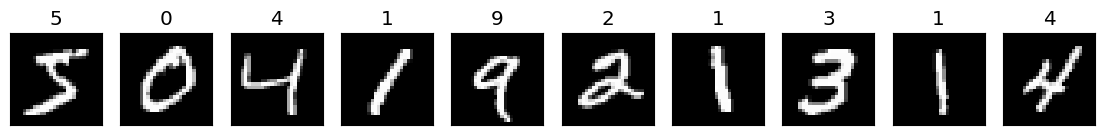

first 10 MNIST-3 data points


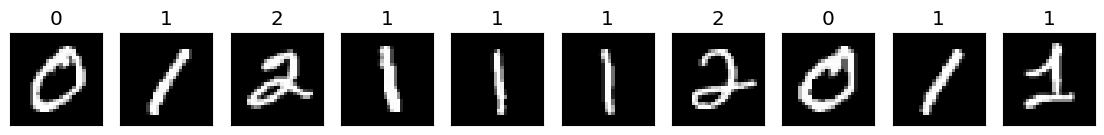

first 10 MNIST-3 data points, binarized


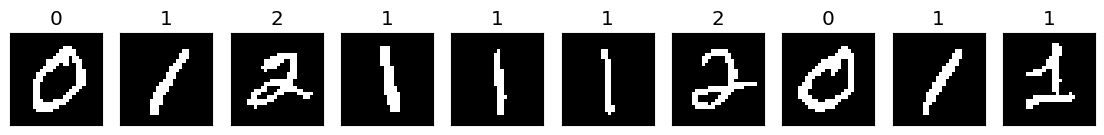

each of Nd=21770 data has D=784 bits


In [4]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')



## Plotting data stats

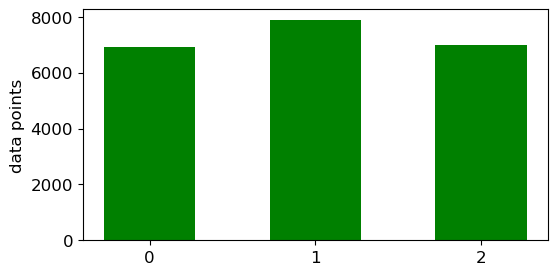

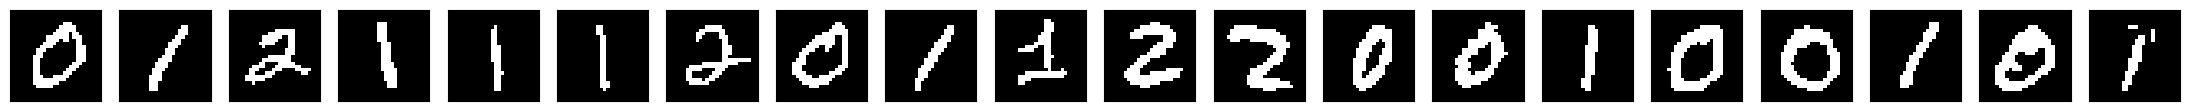

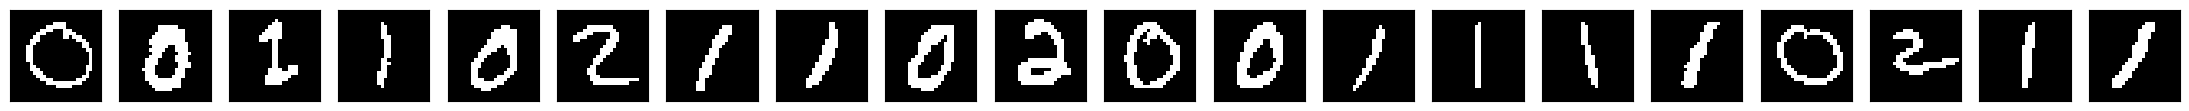

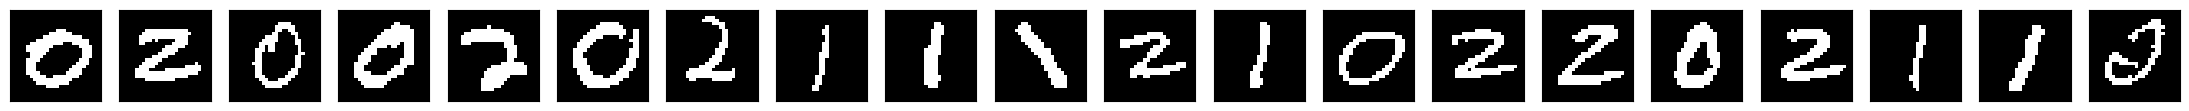

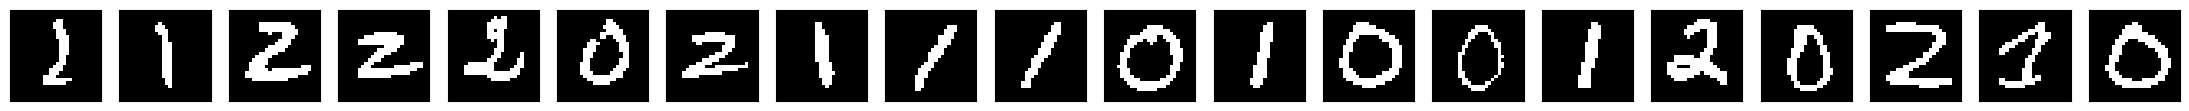

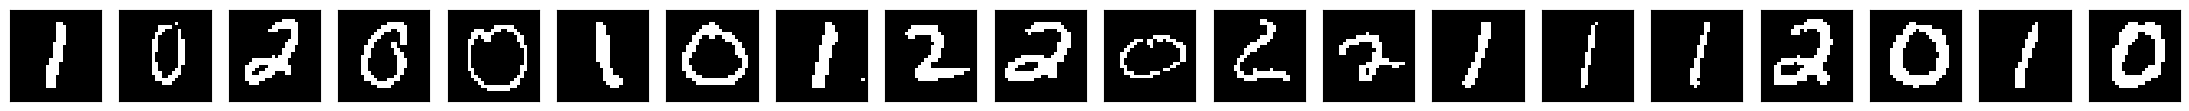

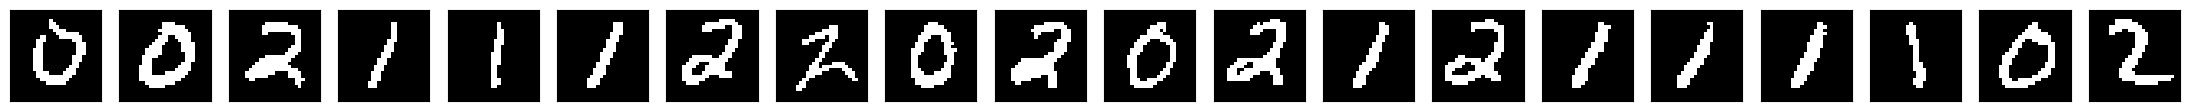

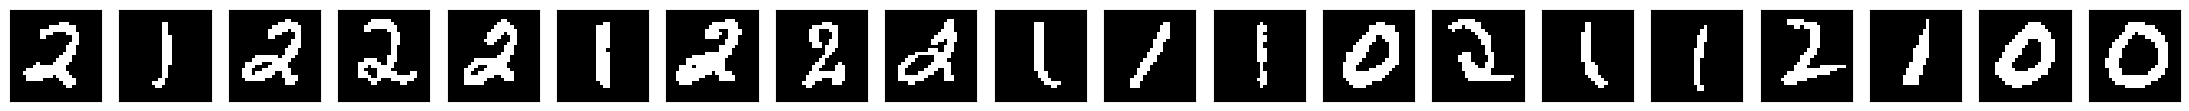

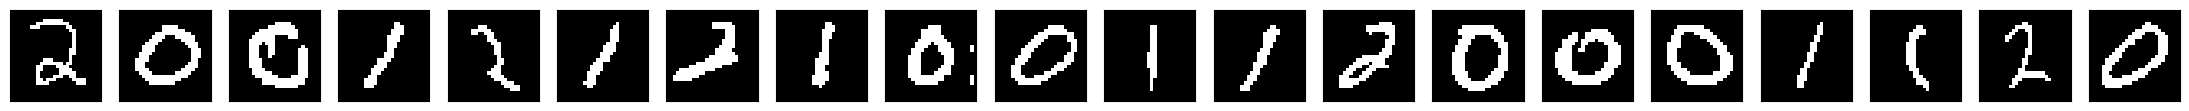

In [5]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [7]:
def plot_weights_bias(wE, bE, epoch, L, side=0,cols=0,thr=0,s=1.5, title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [8]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

# Load Data

In [9]:
def LoadData(WhichFolder, WhichData):

   data_FileList = glob.glob(f"{WhichFolder}/{WhichData}_*") 

   # Load all files into a dictionary
   data = {fname: np.load(fname) for fname in data_FileList}

   #return only the values of the dictionary
   return data

In [10]:
test = LoadData('BM_RandomSearch', 'b')

## Gradient descent method

In [11]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0, 0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05, 0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


# Saving file

In [12]:
def FileName(label, time, hp, FolderName):
   #Label might be: a, b or w, logL
   #hyperparam: [#-if-digits, #-of-hidden-var, CDnumber, optimizr, l_rate_in, l_rate_fin, epochs, gamma, POTTS, SPINS ]

   fname = f'{FolderName}/{label}_RBM_{hp['Ndigit']}_{hp['L']}_{hp['Nt']}_{hp['Opt']}_{hp['l_rate_in']:.2f}-{hp['l_rate_fin']:.2f}_Ep{hp['epochs']}_Mini{hp['mini']}'
   if hp['gamma'] > 0: fname = fname + f'_reg{hp['gamma']:.3f}'
   if hp['POTTS']: fname = fname + f'_POTTS'
   if hp['SPINS']: fname = fname + f'_SPINS'
   fname = fname + time + '.npy'

   return fname

def SaveFile(label, time, hp, data, FolderName):
   fname = FileName(label, time, hp, FolderName)

   np.save(fname, data)


# Log-likelihood $\mathcal{L}$ function

Allow to compute the log likelihood with the training data

In [13]:
def log_likelihood(a, b, w, data):
    
    Z_a = []
    exp_data_dip = []
    L = len(b)
    D = len(data[0])
    q = 1.4
    all_z = list(itertools.product([0, 1], repeat=L))
    for z in all_z:
        G = np.prod([np.exp(z[i]*b[i]) for i in range(len(b))])
        H = a + np.dot(w,z) 
        #q = np.mean(np.ones(len(H))+np.exp(H))
    
        Z_tilde = G*np.prod((np.ones(len(H))+np.exp(H))/q)
        Z_a.append(Z_tilde)

        #Ora voglio ciclare sulle x dei dati (i primi 1000 dati)
        s_prod_exp_tot = 0
        for ics in data:
            s_prod_exp = H.dot(ics)
            s_prod_exp_tot += s_prod_exp
        exp_data_dip.append(s_prod_exp_tot)

    #Z
    Z = np.sum(Z_a)
    log_Z = np.log(Z)+D*np.log(q)
    #log_first_part = np.log(np.sum(np.exp(exp_data_dip)))
    log_first_part = scipy.special.logsumexp(exp_data_dip)
    
    log_L = (log_first_part - log_Z)/D

    return log_L

# RBM train function


In [14]:
DefaultHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

In [ ]:
#'FolderName' is the folder in which we want to save the file: SingleTrain for this, BM_RandomSearch for the random search

def train_RBM(Hyperparams, data, FolderName, Debug = False, LL_Plot = True, ReturnLL = False): 

   #Only to check if the directory FolderName exist
   if os.path.isdir(FolderName):
      print("Directory exists")
   
      L = Hyperparams['L']
      Nepoch = Hyperparams['epochs']
      Nt = Hyperparams['Nt']
      gamma = Hyperparams['gamma']
      l_rate_ini, l_rate_fin = Hyperparams['l_rate_in'], Hyperparams['l_rate_fin']
      GRAD = Hyperparams['Opt']
      POTTS, SPINS = Hyperparams['POTTS'], Hyperparams['SPINS']

      # minibatches per epoch
      Nmini = Hyperparams['mini']
      # minibatch size at initial epoch and final one
      N_ini, N_fin= 10, 400

      print(Hyperparams)

      # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
      w = sigma * np.random.randn(D,L)
      #a = sigma * np.random.randn(D)
      # using Hinton initialization of visible biases
      a = Hinton_bias_init(data)
      # hidden biases initialized to zero
      b = np.zeros(L)

      if Debug: print(f"Nepoch={Nepoch}\nNmini={Nmini}")

      # recording history of weights ("E" means epoch)
      wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
      wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
      gwE,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
      gaE,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
      gbE,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
      miniE = np.zeros(Nepoch+1)
      pzE=np.zeros((Nepoch+1,Nz))
      
      log_L_list = []


      if GRAD=="RMSprop": 
         gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)

      indices=np.arange(Nd).astype("int")

      if Debug:
         plot_weights_bias(wE, aE, 0, L, cols=6, save=False)

      # for the plot with panels
      Ncols=min(8,max(2,L//2))

      if Debug:
         if POTTS: print("Starting the training, POTTS=True")
         else: print("Starting the training")

      # Note: here an epoch does not analyze the whole dataset
      for epoch in tqdm.tqdm(range(1,Nepoch+1)):
         # q maps epochs to interval [0,1]
         q = (epoch-1.)/(Nepoch-1.) 
         # N, size of the mini batch
         # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
         N = int(N_ini + (N_fin-N_ini)*(q**2))
         #  l_rate interpolates between initial and final value
         l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

         selected = np.random.choice(indices, N, replace=False)

         for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
            
            # Minibatch of size N: points randomply picked (without repetition) from data
            #if Debug:
               #if epoch==1 and mini<=3: print(selected)

            for k in range(N):
               ###################################
               x0 = data[selected[k]]
               # positive CD phase: generating z from x[k]
               z = CD_step(x0,w,b,POTTS=POTTS)
               x_data  += x0
               z_data  += z
               xz_data += np.outer(x0,z)
               # fantasy
               zf=np.copy(z)
               # Contrastive divergence with Nt steps
               for t in range(Nt):
                  # negative CD pzase: generating fantasy xf from fantasy zf
                  xf = CD_step(zf,w.T,a)
                  # positive CD phase: generating fantasy zf from fantasy xf 
                  zf = CD_step(xf,w,b,POTTS=POTTS)
               x_model += xf
               z_model += zf
               xz_model+= np.outer(xf,zf)
               # recording probability of encoding in z-space, if POTTS
               if POTTS: pz[zf]+=1
               ###################################
            
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)

            # gradient ascent step
            if GRAD=="RMSprop":
               # RMSprop gradient ascent
               gw2 = beta*gw2+(1-beta)*np.square(gw)
               ga2 = beta*ga2+(1-beta)*np.square(ga)
               gb2 = beta*gb2+(1-beta)*np.square(gb)
               w += l_rate*gw/sqrt(epsilon+gw2)
               a += l_rate*ga/sqrt(epsilon+ga2)
               b += l_rate*gb/sqrt(epsilon+gb2)
            else: 
                  # defaulting to the vanilla stochastic gradient ascent (SGD)
               w += l_rate*gw
               a += l_rate*ga
               b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
               w -= (gamma*l_rate)*sign(w)
               a -= (gamma*l_rate)*sign(a)
               b -= (gamma*l_rate)*sign(b)

         wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
         aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
         bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
         miniE[epoch]=N

         #Computing the likelihood
         log_L = log_likelihood(a, b, w, data)
         log_L_list.append(log_L)

         if POTTS: pzE[epoch] = pz/np.sum(pz)
         # if Debug: 
         #    print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
         #          " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
      
         str_time = datetime.datetime.now().strftime("_%m%d_%H%M")

      if Debug:
         plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)

      SaveFile('w', str_time, Hyperparams, wE, FolderName)
      SaveFile('b', str_time, Hyperparams, bE, FolderName)
      SaveFile('a', str_time, Hyperparams, aE, FolderName)
      SaveFile('logL', str_time, Hyperparams, log_L_list, FolderName)


      
      if Debug: print("END of learning phase")

      if LL_Plot:
         plt.plot(range(Nepoch), log_L_list)
         plt.title("log-Likehood trend")  # Titolo
         plt.xlabel("# epoch")  # Etichetta asse X
         plt.ylabel("log-L")  # Etichetta asse Y
         plt.grid(True)  # Aggiunge una griglia
         plt.show()

      if ReturnLL: 
         return np.mean(log_L_list[-30:]), np.std(log_L_list[-30:])

   else:
      print("Directory does not exist")


Directory exists
{'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

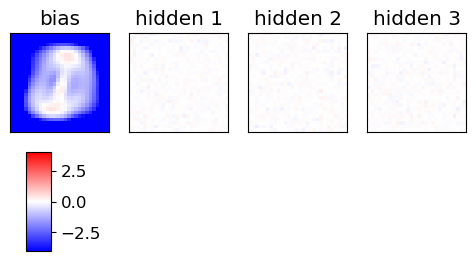

Starting the training


100%|██████████| 150/150 [01:07<00:00,  2.24it/s]


<Figure size 640x480 with 0 Axes>

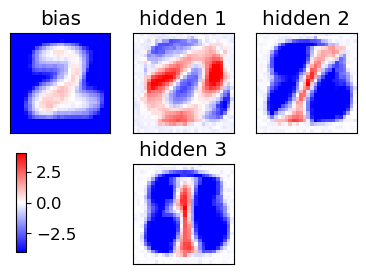

END of learning phase


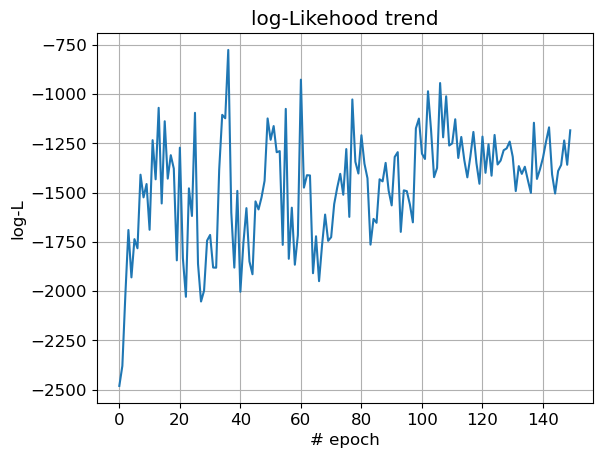

In [18]:
train_RBM(DefaultHyperp, FolderName = 'SingleTrain', Debug = True, LL_Plot = True)

# Verify how $\mathcal{L}$ changes with L and CD

In [77]:
TestHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 
                 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

L_range = [1, 2]
Nt_range = [2, 3]

TestLogLik, stdLL = np.zeros((len(L_range), len(Nt_range))), np.zeros((len(L_range), len(Nt_range)))

for i, l in enumerate(L_range):
   for j, nt in enumerate(Nt_range):
      TestHyperp.update({'L': l, 'Nt': nt})
      LLMean, LLstd = train_RBM(TestHyperp, 'TestTrain', Debug = False, LL_Plot = False, ReturnLL = True)
      TestLogLik[i][j] = LLMean
      stdLL[i][j] = LLstd


Directory exists
{'Ndigit': 3, 'L': 1, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}


  0%|          | 0/175 [00:00<?, ?it/s]

100%|██████████| 175/175 [00:36<00:00,  4.79it/s]


Directory exists
{'Ndigit': 3, 'L': 1, 'Nt': 3, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [00:45<00:00,  3.87it/s]


Directory exists
{'Ndigit': 3, 'L': 2, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [00:57<00:00,  3.06it/s]


Directory exists
{'Ndigit': 3, 'L': 2, 'Nt': 3, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [01:10<00:00,  2.49it/s]


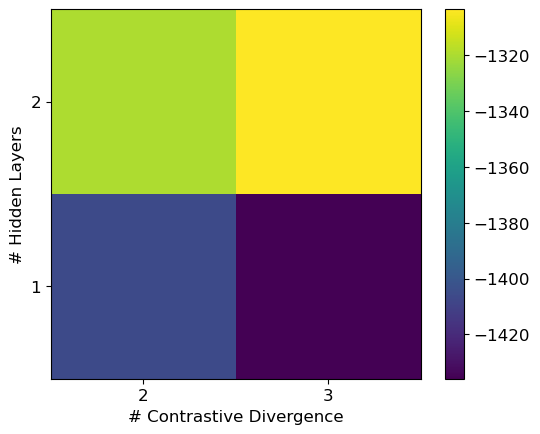

In [119]:

#std_matrix = np.random.rand(2, 2) * 0.6  # Standard deviation values

plt.imshow(TestLogLik)
plt.gca().invert_yaxis()
plt.colorbar()

x, y = np.meshgrid(np.arange(2), np.arange(2))
#plt.scatter(x, y, color='white', s=10)  # Small dots at each point
#plt.errorbar(x.ravel(), y.ravel(), yerr=stdLL.ravel(), fmt='none', ecolor='white', alpha=0.8)
plt.xticks(ticks=np.arange(0, len(Nt_range)), labels=np.arange(2, len(L_range) + 2))
plt.yticks(ticks=np.arange(0, len(L_range)), labels=np.arange(1, len(L_range) + 1))
plt.xlabel("# Contrastive Divergence")
plt.ylabel("# Hidden Layers")


plt.show()


# Implementing the Search

In [ ]:
HP = {'L': [3, 8], 
      'Nt': [2, 6], 
      'Opt': ['RMSprop', 'SGD'],
      'l_rate_in': [1, 0.1], 
      'l_rate_fin': [0.1, 0.05],  
      'mini': [10, 51],
      'gamma': [0.1, 0.001], 
      #'POTTS': [False, True], 
      #'SPINS': False
      }


def RandomSearch(HP, Ndigit = 3, nModels = 10):

   HyperParams_List = []

   for _ in range(nModels):

      L, Nt = np.random.randint(HP['L'][0], HP['L'][1]), np.random.randint(HP['Nt'][0], HP['Nt'][1] )
      l_rate_in = np.round(np.random.uniform(HP['l_rate_in'][0], HP['l_rate_in'][1]), 4)
      l_rate_fin = np.round(np.random.uniform(HP['l_rate_fin'][0], HP['l_rate_fin'][1]), 4)
      mini = np.random.choice(range(HP['mini'][0], HP['mini'][1], 5))
      gamma = np.round(np.random.uniform(HP['gamma'][0], HP['gamma'][1]), 4)

      Opt = np.random.choice(HP['Opt'])

      HyperParams = {'Ndigit': Ndigit, 'L': L, 'Nt': Nt, 'Opt': Opt, 'l_rate_in': l_rate_in, 
                     'l_rate_fin': l_rate_fin, 'epochs': 175, 'mini': mini, 'gamma': gamma, 'POTTS': False, 'SPINS': False}

      HyperParams_List.append(HyperParams)

   return HyperParams_List


In [47]:
HyperParam_List = RandomSearch(HP, nModels = 3)

# Training with all the Models

Directory exists
{'Ndigit': 3, 'L': 5, 'Nt': 5, 'Opt': 'SGD', 'l_rate_in': 0.3199, 'l_rate_fin': 0.0971, 'epochs': 200, 'mini': 15, 'gamma': 0.032, 'POTTS': False, 'SPINS': False}


100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


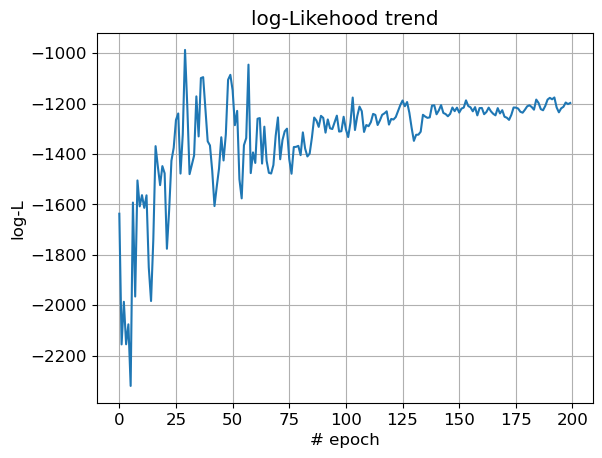

Directory exists
{'Ndigit': 3, 'L': 5, 'Nt': 4, 'Opt': 'RMSprop', 'l_rate_in': 0.844, 'l_rate_fin': 0.0616, 'epochs': 200, 'mini': 30, 'gamma': 0.0898, 'POTTS': False, 'SPINS': False}


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


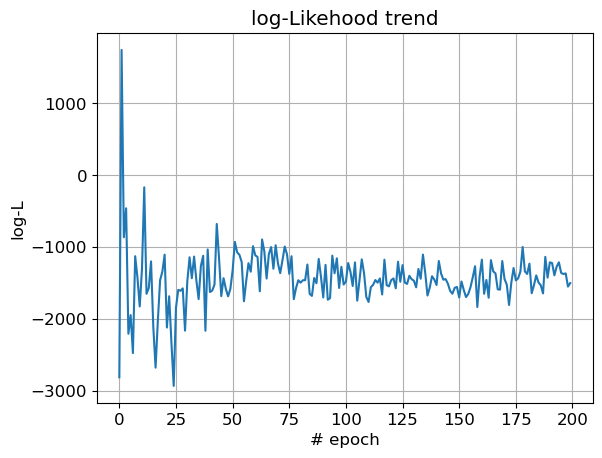

Directory exists
{'Ndigit': 3, 'L': 6, 'Nt': 2, 'Opt': 'SGD', 'l_rate_in': 0.8943, 'l_rate_fin': 0.0695, 'epochs': 200, 'mini': 35, 'gamma': 0.073, 'POTTS': False, 'SPINS': False}


100%|██████████| 200/200 [06:20<00:00,  1.90s/it]


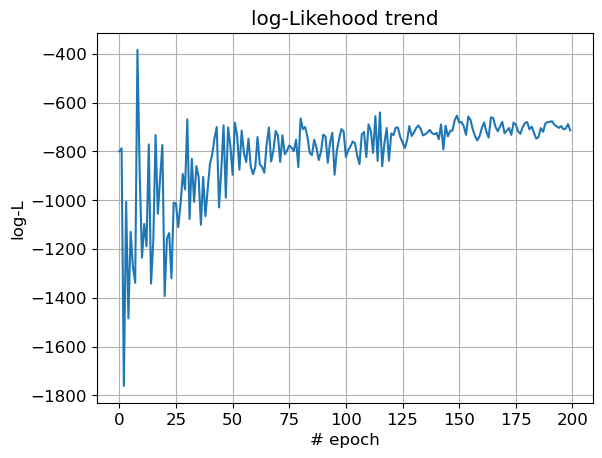

In [48]:
ResultDict = {}

for hyperparams in HyperParam_List:
   mean, std = train_RBM(hyperparams, FolderName = 'BM_RandomSearch', Debug = False, LL_Plot = True, ReturnLL=True)
   ResultDict[f'{hyperparams}'] = (mean, std)

In [ ]:
def OrderingModels(Dictionary):
   return dict(sorted(Dictionary.items(), key=lambda item: item[1], reverse=True))

OrderedResultDict = OrderingModels(ResultDict)


#And then you can do the k-fold validation
#for hp in test1:
   
   

{'Ndigit': 3, 'L': 6, 'Nt': 2, 'Opt': 'SGD', 'l_rate_in': 0.8943, 'l_rate_fin': 0.0695, 'epochs': 200, 'mini': 35, 'gamma': 0.073, 'POTTS': False, 'SPINS': False}
{'Ndigit': 3, 'L': 5, 'Nt': 5, 'Opt': 'SGD', 'l_rate_in': 0.3199, 'l_rate_fin': 0.0971, 'epochs': 200, 'mini': 15, 'gamma': 0.032, 'POTTS': False, 'SPINS': False}
{'Ndigit': 3, 'L': 5, 'Nt': 4, 'Opt': 'RMSprop', 'l_rate_in': 0.844, 'l_rate_fin': 0.0616, 'epochs': 200, 'mini': 30, 'gamma': 0.0898, 'POTTS': False, 'SPINS': False}


## Test generative power of the trained RBM

In [ ]:
#aE = np.load('WEIGHTS/a_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_reg0.001_0312_1502.npy')
#bE = np.load('WEIGHTS/b_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_reg0.001_0312_1502.npy')
#wE = np.load('WEIGHTS/w_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_reg0.001_0312_1502.npy')

ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=10.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, 150, L, cols=3, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF )

## Plot of the gradient amplitude

In [ ]:
NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()


plt.show()


# codice di Marco 

In [ ]:
W = wE[Nepoch]
a = aE[epoch]
b = bE[epoch]

selectA = 1
selectB = 2
index_selectA = np.random.choice( np.where(label == selectA)[0] )
index_selectB = np.random.choice( np.where(label == selectB)[0] )
dataA = data[index_selectA]
dataB = data[index_selectB]

zA = CD_step(dataA,W,b)
zB = CD_step(dataB,W,b)

def energy(x, z, W, a, b):
    return -(np.dot(x, a) + np.dot(z, b) + np.dot(x, np.dot(W , z)))

n_steps = 100
energies = []
intermediate_images = []

for alpha in np.linspace(0, 1, n_steps):
    # PART OVERCOME BARRIER
    '''
    x_intermediate = np.zeros(D)
    #ora per ogni pixel, decido con la soglia random se prendere il valore da dataA o da dataB
    for i in range(D):
        if np.random.uniform() > alpha:
            x_intermediate[i] = dataA[i]
        else:
            x_intermediate[i] = dataB[i]
    '''
    # ----------------------
    # PART SHOW BARRIER
    x_intermediate = (1 - alpha) * dataA + alpha * dataB  # Interpolazione lineare
    x_intermediate = (x_intermediate > 0.5).astype(int)  # Soglia binaria
    z_intermediate = CD_step(x_intermediate, W, b,)
    # ----------------------
    E = energy(x_intermediate, z_intermediate, W, a, b)
    energies.append(E)
    intermediate_images.append(x_intermediate.reshape(28, 28))


plt.figure(figsize=(8, 4))
plt.plot(range(n_steps), energies, marker='o')
plt.xlabel(f"Linear transition between {selectA} and {selectB}")
plt.ylabel("Energy")
plt.title(f"Energetic barrier between {selectA} and {selectB}")
plt.grid()
plt.show()

# show some intermediate step
show_inter_steps = 5
fig, axes = plt.subplots(1, show_inter_steps, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(intermediate_images[i * (n_steps // show_inter_steps)], cmap='gray')
    ax.axis('off')
plt.show()

In [ ]:
W = wE[Nepoch]
a = aE[epoch]
b = bE[epoch]

selectA = 1
selectB = 2
index_selectA = np.random.choice( np.where(label == selectA)[0] )
index_selectB = np.random.choice( np.where(label == selectB)[0] )
dataA = data[index_selectA]
dataB = data[index_selectB]

zA = CD_step(dataA,W,b)
zB = CD_step(dataB,W,b)

def energy(x, z, W, a, b):
    return -(np.dot(x, a) + np.dot(z, b) + np.dot(x, np.dot(W , z)))

n_steps = 100
energies = []
intermediate_images = []

for alpha in np.linspace(0, 1, n_steps):
    # PART OVERCOME BARRIER
    x_intermediate = np.zeros(D)
    #ora per ogni pixel, decido con la soglia random se prendere il valore da dataA o da dataB
    for i in range(D):
        if np.random.uniform() > alpha:
            x_intermediate[i] = dataA[i]
        else:
            x_intermediate[i] = dataB[i]
    # ----------------------
    '''
    # PART SHOW BARRIER
    x_intermediate = (1 - alpha) * dataA + alpha * dataB  # Interpolazione lineare
    x_intermediate = (x_intermediate > 0.5).astype(int)  # Soglia binaria
    z_intermediate = CD_step(x_intermediate, W, b,)
    # ----------------------
    '''
    E = energy(x_intermediate, z_intermediate, W, a, b)
    energies.append(E)
    intermediate_images.append(x_intermediate.reshape(28, 28))


plt.figure(figsize=(8, 4))
plt.plot(range(n_steps), energies, marker='o')
plt.xlabel(f"Random transition between {selectA} and {selectB}")
plt.ylabel("Energy")
plt.title(f"Energetic barrier between {selectA} and {selectB}")
plt.grid()
plt.show()

# show some intermediate step
show_inter_steps = 5
fig, axes = plt.subplots(1, show_inter_steps, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(intermediate_images[i * (n_steps // show_inter_steps)], cmap='gray')
    ax.axis('off')
plt.show()